In [1]:
!pip install torchsummary
!pip install grad-cam
!pip install torch-lr-finder

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torchsummary import summary

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
from models.resnet import ResNet18
from dataloader import Cifar10SearchDataset
from utils import CustomResnetTransforms, visualise_train_images, \
                  plot_curves, get_misclassified_images, plot_misclassified, plot_grad_cam_images
from main import get_dataloader, train, test, find_lr, get_scheduler, get_dataloader

In [4]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

train_transforms = CustomResnetTransforms.train_transforms(means, stds)
test_transforms = CustomResnetTransforms.test_transforms(means, stds)

train_set = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test_set = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

cuda
Files already downloaded and verified
Files already downloaded and verified


In [5]:
SEED = 1

# For reproducibility
torch.manual_seed(SEED)

# train dataloader
train_loader = get_dataloader(train_set, batch_size=512)

# test dataloader
test_loader = get_dataloader(test_set, batch_size=512)

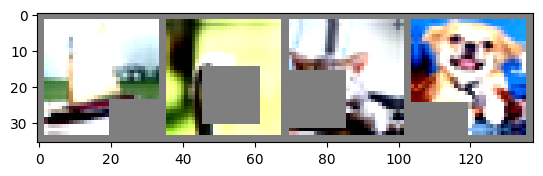

ship  bird  cat   dog  


In [6]:
# get some random training images
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
visualise_train_images(train_loader, classes)

In [7]:
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.07E-02


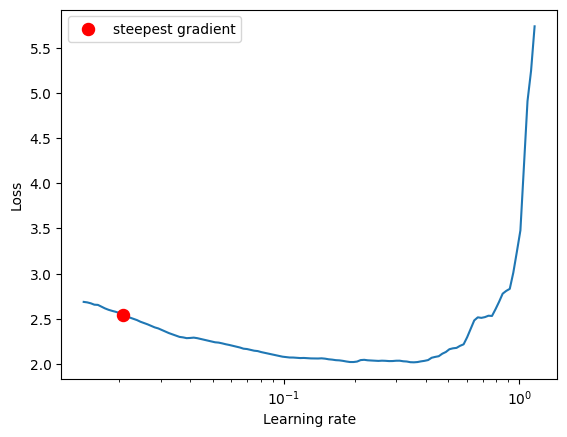

In [8]:
model = ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
find_lr(model, optimizer, criterion, train_loader, device)

In [9]:
suggested_lr = 2.07E-02

In [10]:
model =  ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
EPOCHS = 20

scheduler = get_scheduler(optimizer, train_loader, suggested_lr, EPOCHS)

criterion = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')
    train_losses, train_acc = train(model, device, train_loader, optimizer, criterion, scheduler, train_losses, train_acc)
    test_losses, test_acc = test(model, device, test_loader, criterion, test_losses, test_acc)

Epoch 1


Train: Loss=1.2231 Batch_id=97 Accuracy=42.89: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]


Test set: Average loss: 1.6922, Accuracy: 4641/10000 (46.41%)

Epoch 2


Train: Loss=1.1018 Batch_id=97 Accuracy=56.15: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 2.1181, Accuracy: 4062/10000 (40.62%)

Epoch 3


Train: Loss=0.9858 Batch_id=97 Accuracy=63.03: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 1.8550, Accuracy: 4761/10000 (47.61%)

Epoch 4


Train: Loss=0.8460 Batch_id=97 Accuracy=66.44: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.9372, Accuracy: 6800/10000 (68.00%)

Epoch 5


Train: Loss=0.9520 Batch_id=97 Accuracy=68.91: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]


Test set: Average loss: 1.2940, Accuracy: 5826/10000 (58.26%)

Epoch 6


Train: Loss=0.8083 Batch_id=97 Accuracy=70.07: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 1.1254, Accuracy: 6448/10000 (64.48%)

Epoch 7


Train: Loss=0.9188 Batch_id=97 Accuracy=71.93: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.7443, Accuracy: 7440/10000 (74.40%)

Epoch 8


Train: Loss=0.6693 Batch_id=97 Accuracy=73.23: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Test set: Average loss: 1.0551, Accuracy: 6681/10000 (66.81%)

Epoch 9


Train: Loss=0.6159 Batch_id=97 Accuracy=74.66: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.8502, Accuracy: 7201/10000 (72.01%)

Epoch 10


Train: Loss=0.5992 Batch_id=97 Accuracy=75.69: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.8563, Accuracy: 7095/10000 (70.95%)

Epoch 11


Train: Loss=0.6983 Batch_id=97 Accuracy=77.03: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.9338, Accuracy: 7017/10000 (70.17%)

Epoch 12


Train: Loss=0.5648 Batch_id=97 Accuracy=78.07: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Test set: Average loss: 0.6659, Accuracy: 7759/10000 (77.59%)

Epoch 13


Train: Loss=0.5486 Batch_id=97 Accuracy=78.98: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.5864, Accuracy: 8034/10000 (80.34%)

Epoch 14


Train: Loss=0.5513 Batch_id=97 Accuracy=80.22: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.5956, Accuracy: 8054/10000 (80.54%)

Epoch 15


Train: Loss=0.5557 Batch_id=97 Accuracy=81.18: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Test set: Average loss: 0.6126, Accuracy: 8064/10000 (80.64%)

Epoch 16


Train: Loss=0.4929 Batch_id=97 Accuracy=82.49: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.5034, Accuracy: 8320/10000 (83.20%)

Epoch 17


Train: Loss=0.3987 Batch_id=97 Accuracy=84.04: 100%|██████████| 98/98 [00:41<00:00,  2.33it/s]


Test set: Average loss: 0.3871, Accuracy: 8718/10000 (87.18%)

Epoch 18


Train: Loss=0.3957 Batch_id=97 Accuracy=86.12: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.4311, Accuracy: 8630/10000 (86.30%)

Epoch 19


Train: Loss=0.3812 Batch_id=97 Accuracy=87.84: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.3052, Accuracy: 9007/10000 (90.07%)

Epoch 20


Train: Loss=0.2781 Batch_id=97 Accuracy=90.00: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.2667, Accuracy: 9153/10000 (91.53%)



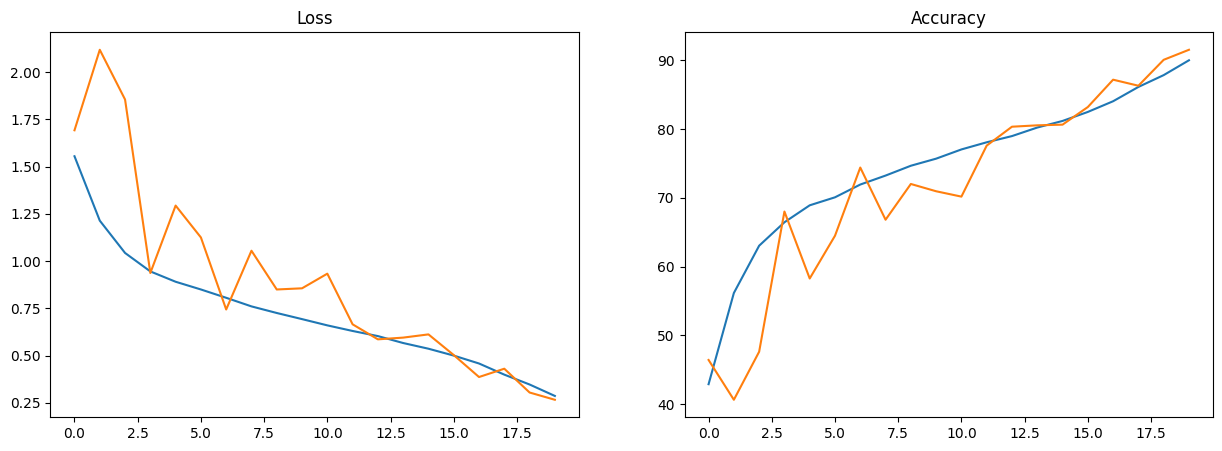

In [11]:
#plot of loss and accuracy curve
plot_curves(train_losses, train_acc, test_losses, test_acc)

In [12]:
#finding misclassifies images and ploting misclassified images
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True)

misclassified_images, misclassified_predictions, true_targets = get_misclassified_images(model, cifar_testset, means, stds, device)

Files already downloaded and verified


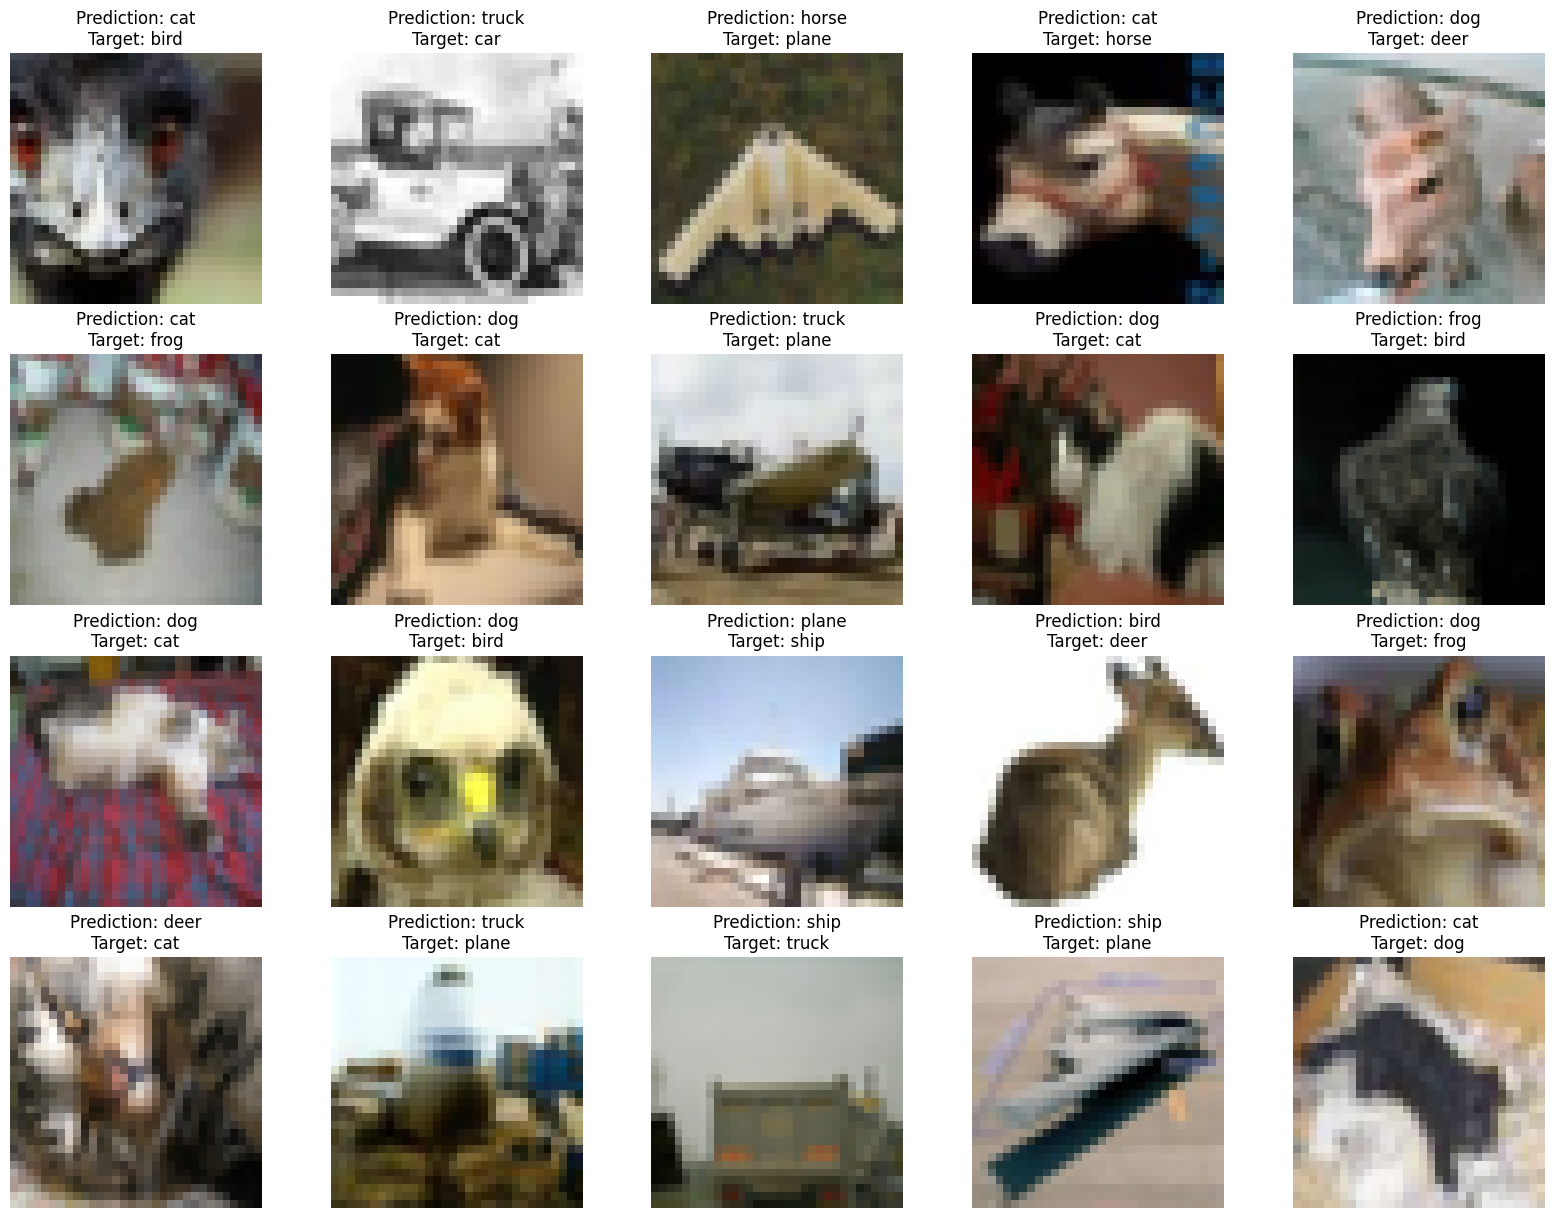

In [23]:
plot_misclassified(misclassified_images, misclassified_predictions, true_targets, classes)

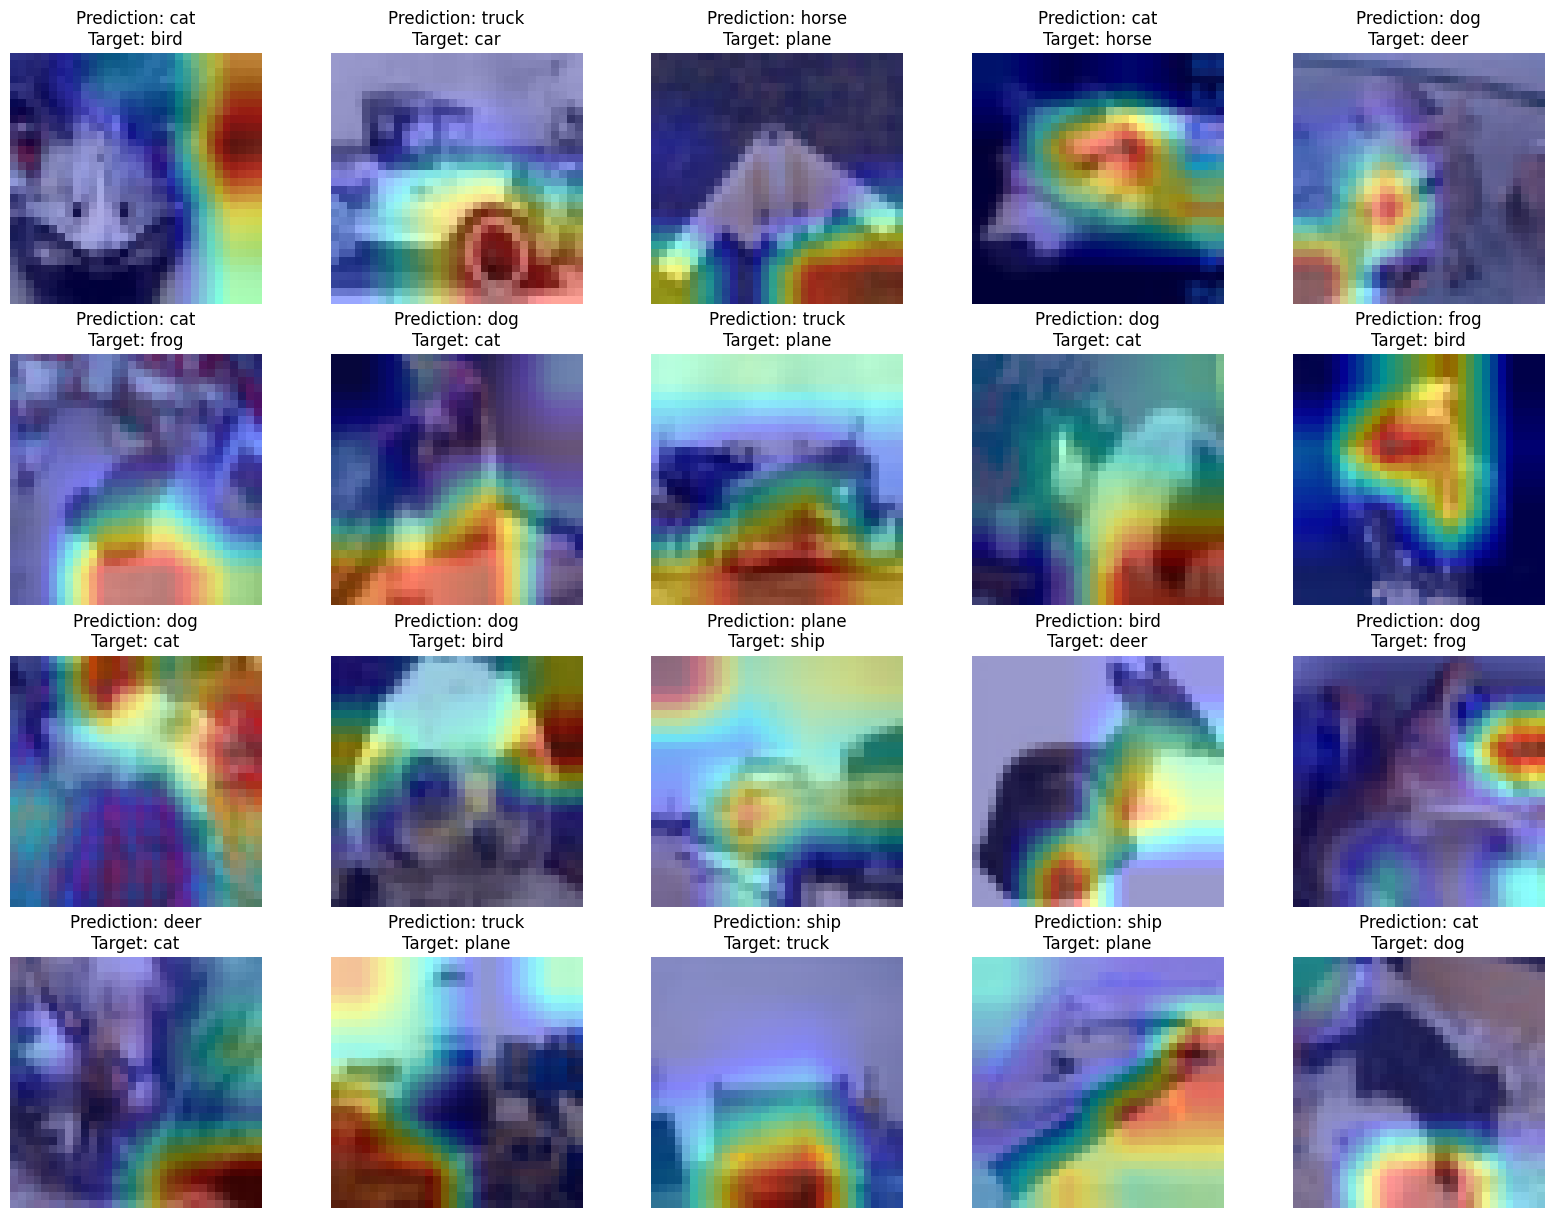

In [22]:
plot_grad_cam_images(misclassified_images, misclassified_predictions, true_targets, classes, model)